In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as dt
import mplcyberpunk

import warnings
warnings.filterwarnings("ignore")
plt.style.use("cyberpunk")

todo: two models (one with train/test), one on full data with new prediction for next 2 days/few hours?

Loading data

In [ ]:
data = pd.read_csv(r'') 
timeseries = data[["Kp index"]].values.astype('float32') # model's target prediction
# plt.figure(figsize=(16,8))
# plt.plot(timeseries)
# plt.title('Recording of KP index between 2015-2025')
# mplcyberpunk.add_glow_effects()
# plt.show()
timeseries

array([[1.333],
       [0.667],
       [0.333],
       ...,
       [2.   ],
       [1.667],
       [1.   ]], shape=(29024, 1), dtype=float32)

Train/test split (80/20)

In [4]:
train_size = int(len(timeseries) * 0.8)
test_size = len(timeseries) - train_size
train, test = timeseries[:train_size], timeseries[train_size:]
print(f'Test set size: {len(train)}')
print(f'Train set size: {len(test)}')

Test set size: 23219
Train set size: 5805


Function for reshaping training data into a prediction dataset (using sliding window method)

In [18]:
def create_dataset_sliding_window(df, lookback): # lookback - size of window
    X, y = [], [] # datasets divided into chunks of data

    for i in range(len(df) - lookback):
        feature = df[i:i+lookback] # ex. 0:8, used for model input
        target = df[i+1:i+lookback+1] # 1:9, used for prediction, a step into the future
        X.append(feature)
        y.append(target)
        
    return torch.tensor(X), torch.tensor(y)

In [17]:
lookback = 8 # a whole day in data, measured every 3 hours

X_train, y_train = create_dataset_sliding_window(train, lookback)
X_test, y_test = create_dataset_sliding_window(test, lookback)

Model structure

In [ ]:
class AuroraModel(nn.Module):
    def __init__(self):
        super().__init__() # num of features, neurons in hidden state, batch_first = 
        self.lstm = nn.LSTM(input_size=1, hidden_size=50,
                            num_layers=1, batch_first=True)
        self.linear = nn.Linear(50, 1)
    def forward(self, x):
        x, _ = self.lstm(x)
        x = self.linear(x)
        return x

Function for training model

In [ ]:
def train_model(model, n_epochs, loader, optimizer, loss_fn):
    train_loss = []

    for epoch in range(n_epochs):
        model.train() # not really needed
        for X_batch, y_batch in loader:
            y_pred = model(X_batch)
            loss = loss_fn(y_pred, y_batch) # calculate difference between predicted val and true val
            train_loss.append(loss)
            optimizer.zero_grad() 
            loss.backward()
            optimizer.step()

        if epoch % 10 != 0:
            continue
        model.eval() # not really needed
        
        with torch.no_grad():
            y_pred = model(X_train)
            train_rmse = np.sqrt(loss_fn(y_pred, y_train))
           # train_loss.append(train_rmse) replace
            y_pred = model(X_test)
            test_rmse = np.sqrt(loss_fn(y_pred, y_test))
        print(f'Epoch {epoch}, train RMSE: {train_rmse}, test RMSE: {test_rmse}')

    return train_loss

In [23]:
model = AuroraModel()
optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.MSELoss()
loader = dt.DataLoader(dt.TensorDataset(X_train, y_train), shuffle=True, batch_size=8) # read what it does 
print(model)

AuroraModel(
  (lstm): LSTM(1, 50, batch_first=True)
  (linear): Linear(in_features=50, out_features=1, bias=True)
)


todo: wayy more epochs, train on colab

In [24]:
history = train_model(model, 200, loader, optimizer, loss_fn)

Epoch 0, train RMSE: 0.7838638424873352, test RMSE: 0.8530678153038025
Epoch 10, train RMSE: 0.7800914645195007, test RMSE: 0.8405215740203857
Epoch 20, train RMSE: 0.7787154316902161, test RMSE: 0.8472802639007568
Epoch 30, train RMSE: 0.7769966125488281, test RMSE: 0.8503375053405762
Epoch 40, train RMSE: 0.774920642375946, test RMSE: 0.8585521578788757
Epoch 50, train RMSE: 0.7713444232940674, test RMSE: 0.8515523672103882
Epoch 60, train RMSE: 0.7687345743179321, test RMSE: 0.8566944003105164
Epoch 70, train RMSE: 0.7645493149757385, test RMSE: 0.8657143115997314
Epoch 80, train RMSE: 0.7590987086296082, test RMSE: 0.8644614219665527
Epoch 90, train RMSE: 0.7547460198402405, test RMSE: 0.8726174831390381
Epoch 100, train RMSE: 0.7502744197845459, test RMSE: 0.8790318965911865
Epoch 110, train RMSE: 0.7476261258125305, test RMSE: 0.8853249549865723
Epoch 120, train RMSE: 0.7435891032218933, test RMSE: 0.8857391476631165
Epoch 130, train RMSE: 0.7413598895072937, test RMSE: 0.8919797

In [35]:
def plot_loss(history):
    history = [loss.item() for loss in history]
    plt.figure(figsize=(16,8))
    plt.plot(history)
    plt.title('Test loss')
    mplcyberpunk.add_glow_effects()
    plt.show()

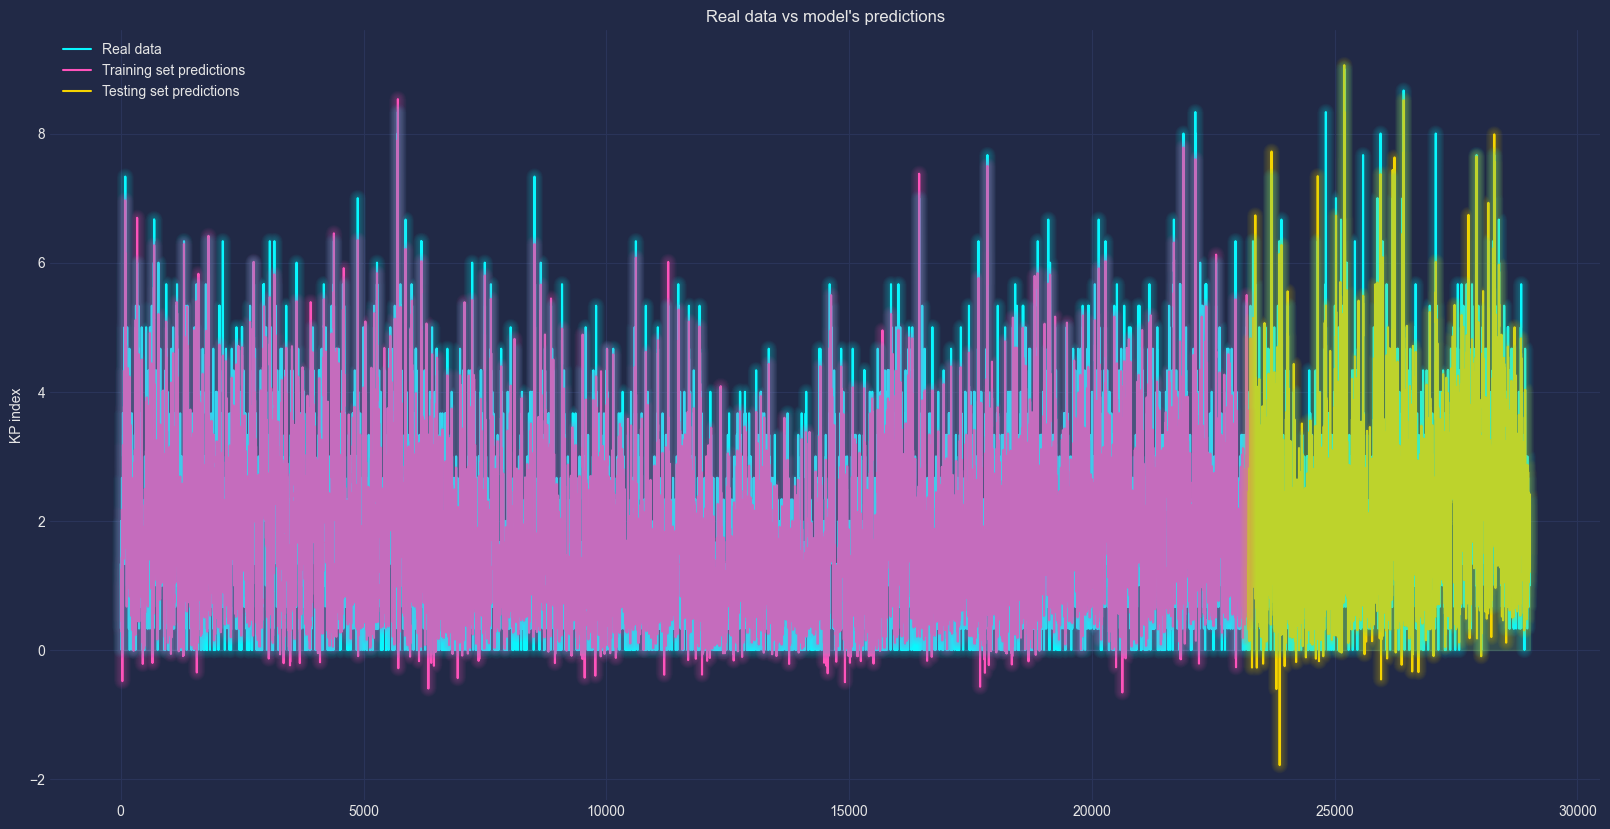

In [38]:
with torch.no_grad():
    # shift train predictions for plotting
    train_plot = np.ones_like(timeseries) * np.nan
    y_pred = model(X_train) # model's predictions for training set
    y_pred = y_pred[:, -1, :]
    train_plot[lookback:train_size] = model(X_train)[:, -1, :]
    # shift test predictions for plotting
    test_plot = np.ones_like(timeseries) * np.nan
    test_plot[train_size+lookback:len(timeseries)] = model(X_test)[:, -1, :] # model's predictions for testing set
# plot
plt.figure(figsize=(20,10))
plt.plot(timeseries, label="Real data")
plt.plot(train_plot, label="Training set predictions")
plt.plot(test_plot, label="Testing set predictions")
plt.title("Real data vs model's predictions")
plt.ylabel("KP index")
plt.legend()
mplcyberpunk.add_glow_effects()
plt.show()

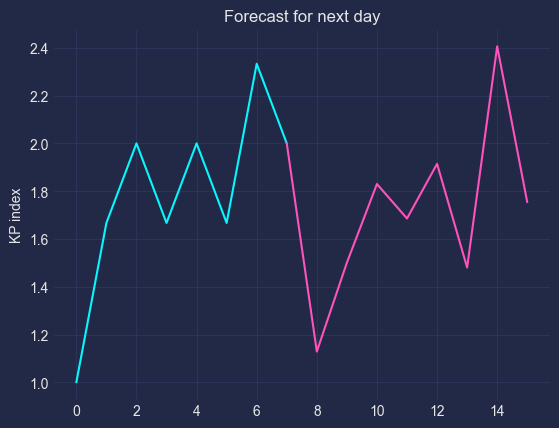

In [138]:
to_predict = y_test[-lookback]  # last available input sequence
to_predict_plot = [value.item() for value in to_predict]
model_new_pred = model(to_predict)
pred_list = [value.item() for value in model_new_pred]

new_pred_plot = np.full(shape=len(pred_list)+len(pred_list), fill_value=np.nan)
new_pred_plot[len(to_predict_plot)-1] = to_predict_plot[-1]
new_pred_plot[len(to_predict_plot):] = pred_list

plt.plot(to_predict_plot)
plt.plot(new_pred_plot)
plt.title('Forecast for next day')
plt.ylabel('KP index')
plt.show()

In [139]:
torch.save(model.state_dict(), 'test_model.pt')